In [50]:
###########################   Part 1 : Data Preprocessing   ############################

In [51]:
# Importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [52]:
import warnings
warnings.filterwarnings("ignore")

In [53]:
# Loading the data
file_name = "reviews.csv"
reviews = pd.read_csv(file_name)
reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


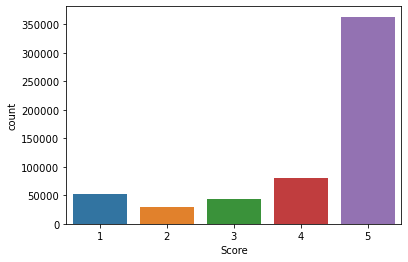

In [54]:
# Visualizing the score
fig, ax = plt.subplots()
sns.countplot(x="Score", data=reviews)
plt.show()

In [55]:
# Removing rows with score of 3
filtered_reviews = reviews.loc[reviews["Score"].isin([1, 2, 4, 5])]

def category(x):
    if x > 3:
        return 1
    else:
        return 0
    
ratings = filtered_reviews["Score"].map(category)
filtered_reviews["Score"] = ratings

filtered_reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [56]:
# Data cleaning
sorted_reviews = filtered_reviews.sort_values(by="ProductId", axis=0, ascending=True)
final_reviews = sorted_reviews.drop_duplicates(subset={"UserId", "ProfileName", "Time", "Text"}, keep="first", inplace=False)
final_reviews.shape

(364173, 10)

In [57]:
# % of data left
(final_reviews.size*1.0 / filtered_reviews.size*1.0) * 100

69.25890143662969

In [58]:
# Removing incorrect entries
final_reviews = final_reviews[final_reviews.HelpfulnessNumerator <= final_reviews.HelpfulnessDenominator]
final_reviews.shape

(364171, 10)

In [59]:
# Value counts
final_reviews["Score"].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [60]:
# Making a list of stopwords
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer("english")
stop_words = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pradip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [61]:
# Text preprocessing
from tqdm import tqdm
from bs4 import BeautifulSoup
import re
#import contractions
preprocessed_reviews = []

for sentence in tqdm(final_reviews['Text'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    #sentence = contractions.fix(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    sentence = sentence.lower()
    sentence = stemmer.stem(sentence)
    sentence = " ".join([word for word in sentence.split() if word not in stop_words])
    preprocessed_reviews.append(sentence)

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [05:24<00:00, 1123.23it/s]


In [62]:
# Saving the cleaned text into a csv
final_reviews["Cleaned Text"] = preprocessed_reviews
final_reviews.to_csv(path_or_buf="cleaned_reviews.csv", index=False)

In [63]:
# Creating vocubulary
corpus = []

for text in tqdm(final_reviews["Cleaned Text"]):
    for word in text.strip().split():
        corpus.append(word.strip())
    
print(len(corpus))

100%|███████████████████████████████████████████████████████████████████████| 364171/364171 [00:07<00:00, 47132.27it/s]

13777592


In [64]:
# Word count
from collections import Counter
word_count = Counter(corpus)
print("Unique words =", len(word_count))
word_count.most_common(5)

Unique words = 116760


[('like', 153172),
 ('good', 124095),
 ('great', 108403),
 ('one', 106798),
 ('taste', 104920)]

In [65]:
# Creating word count dataframe
word_count_df = []

for idx, (word, count) in enumerate(word_count.most_common(len(word_count))):
    word_count_df.append([idx+1, word, count])

word_count_df = pd.DataFrame(columns=["Index", "Word", "Count"], data=word_count_df)    
word_count_df.head()

,Index,Word,Count
0,1,like,153172
1,2,good,124095
2,3,great,108403
3,4,one,106798
4,5,taste,104920


In [66]:
# Creating word count dictionary
word_count_dict = {}

for _, row in word_count_df.iterrows():
    word_count_dict[row["Word"]] = [row["Index"], row["Count"]]
    
print(len(word_count_dict))

116760


In [67]:
# Data preprocessing
indexed_X = []
indexed_y = []

for sentence in final_reviews["Cleaned Text"]:
    indexed_X.append([word_count_dict[word][0] for word in sentence.strip().split()])

indexed_y = final_reviews["Score"]

In [68]:
# Data loader
from sklearn.model_selection import train_test_split

def load_data(num_words, test_size):
    X = indexed_X
    y = indexed_y
    
    for i in range(len(X)):
        for j in range(len(X[i])):
            if X[i][j] > num_words:
                X[i][j] = 0
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    return (X_train, y_train), (X_test, y_test)

In [69]:
###########################   Part 2 : Model Building   ############################

In [70]:
# Importing libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence

In [71]:
# Splitting data
top_words = 5000
test_size = 0.33
(X_train, y_train), (X_test, y_test) = load_data(num_words=top_words, test_size=test_size)

In [72]:
# Truncate and/or pad input sequences
max_review_length = 100

X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(243994, 100)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0  153  308  851  795    0    0 1315  551   16  952
 1129  217 2350  904 2808  781  790 1154  707    7  806    0  154  767
 2581    0]


In [73]:
# Build the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           160032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 184,929
Trainable params: 184,929
Non-trainable params: 0
_________________________________________________________________
None


In [74]:
###########################   Part 3 : Model Evaluation   ############################

In [75]:
# Run the model
model.fit(X_train, y_train, epochs=5, batch_size=64)
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/5
3813/3813 [==============================] - 266s 70ms/step - loss: 0.2125 - accuracy: 0.9161
Epoch 2/5
3813/3813 [==============================] - 273s 72ms/step - loss: 0.1754 - accuracy: 0.9306
Epoch 3/5
3813/3813 [==============================] - 283s 74ms/step - loss: 0.1601 - accuracy: 0.9370
Epoch 4/5
3813/3813 [==============================] - 291s 76ms/step - loss: 0.1478 - accuracy: 0.9422
Epoch 5/5
3813/3813 [==============================] - 287s 75ms/step - loss: 0.1356 - accuracy: 0.9471
Accuracy: 93.11%
